In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [17]:
pip install evaluate

Keyring is skipped due to an exception: 'keyring.backends'
     |████████████████████████████████| 124 kB 1.8 MB/s eta 0:00:01
ERROR: requests 2.22.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 2.0.7 which is incompatible.
ERROR: lightning 1.9.5 has requirement fastapi<0.89.0, but you'll have fastapi 0.103.1 which is incompatible.
ERROR: lightning 1.9.5 has requirement PyYAML<8.0,>=5.4, but you'll have pyyaml 5.3 which is incompatible.
ERROR: botocore 1.33.13 has requirement urllib3<1.27,>=1.25.4; python_version < "3.10", but you'll have urllib3 2.0.7 which is incompatible.
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.8
    Uninstalling urllib3-1.25.8:
      Successfully uninstalled urllib3-1.25.8
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install datasets

In [18]:
!pip install jiwer

Keyring is skipped due to an exception: 'keyring.backends'


In [32]:
!pip install pytorch-lightning

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached pytorch_lightning-1.9.5-py3-none-any.whl (829 kB)
  Using cached PyYAML-6.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (670 kB)
     |████████████████████████████████| 127 kB 778 kB/s eta 0:00:01
ERROR: lightning 1.9.5 has requirement fastapi<0.89.0, but you'll have fastapi 0.103.1 which is incompatible.
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.3
ERROR: Cannot uninstall 'PyYAML'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [ ]:
!pip install tqdm==4.59.0

In [14]:
from datasets import load_dataset

# If the dataset is gated/private, make sure you have run huggingface-cli login
ds = load_dataset("MedIR/roco")

Found cached dataset parquet (/home/computer/.cache/huggingface/datasets/MedIR___parquet/MedIR--roco-1d51a43c5759b86d/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
ds = ds["test"].train_test_split(test_size=0.1)

In [17]:
ds = ds.rename_column("caption", "text")

In [18]:
ds = ds.remove_columns(['id', 'semtypes', 'cuis'])

In [19]:
from datasets import Dataset

In [35]:
train_ds = Dataset.from_dict(ds['train'][0:50])

In [36]:
train_ds.num_rows

50

In [37]:
test_ds = Dataset.from_dict(ds['test'][0:25])

In [38]:
test_ds.num_rows

25

In [39]:
print(type(train_ds))
print(type(test_ds))

<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>


In [40]:
from PIL import features
print (features.check_module('webp'))

True


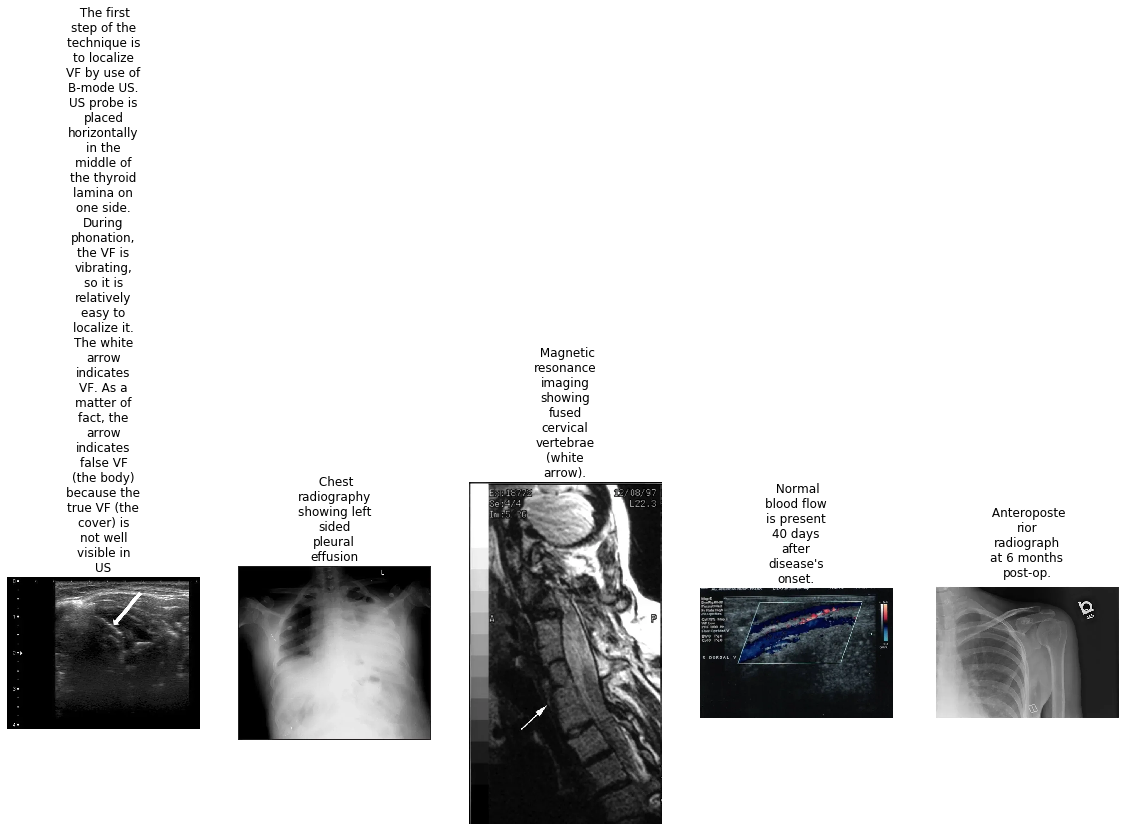

In [41]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

In [61]:
from transformers import AutoProcessor#, Autot

checkpoint = "microsoft/git-base-coco"
processor = AutoProcessor.from_pretrained(checkpoint)

In [62]:
train_ds.features['text']

Value(dtype='string', id=None)

In [63]:
def transforms(example_batch):
    images = [i for i in example_batch["image"]]
    captions = [i for i in example_batch["text"]]
    max_length = 32
    inputs = processor(captions,images, padding='max_length', truncation=True, max_length=max_length)#, skip_special_tokens=False)
    #print(inputs)
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [64]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [65]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels)#, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted)#, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [66]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-cxray",
    learning_rate=1e-2,
    num_train_epochs=5,
    #fp16=True,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=1,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=15,
    save_strategy="steps",
    save_steps=15,
    logging_steps=5,
    remove_unused_columns=False,
    #push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True
)

In [67]:
from lightning.pytorch.loggers import CSVLogger
logger = CSVLogger("logs", name="my_exp_name")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [49]:
trainer.train()

/home/computer/anaconda3/lib/python3.7/site-packages/transformers/optimization.py:415: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss,Wer Score
15,17.230200,13.842622,1.000000
30,10.193700,13.993231,9.063107
45,10.297000,10.539163,9.262136
60,8.369900,10.228338,9.063107
75,5.057800,9.182061,9.063107
90,5.744400,8.830954,9.063107
105,5.695000,8.354242,9.063107
120,6.173600,8.455438,9.063107


TrainOutput(global_step=125, training_loss=8.80150437927246, metrics={'train_runtime': 453.6685, 'train_samples_per_second': 0.551, 'train_steps_per_second': 0.276, 'total_flos': 7307541216000.0, 'train_loss': 8.80150437927246, 'epoch': 5.0})

In [50]:
#Frontal view in a supine patient demonstrates opacity in the right lower lung.
#As the patient is supine, it is difficult to discern the air fluid level,
#however, fluid density surrounding the right lung is present.

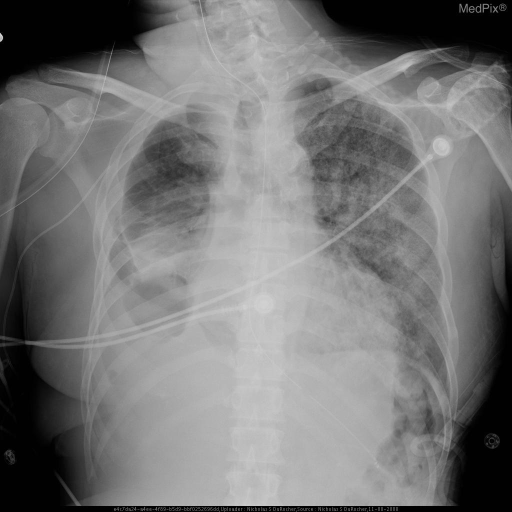

In [68]:
from PIL import Image
image = Image.open('./medical.png')
image

In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

cpu


In [70]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
print(generated_caption)

["a black and white image of a man's back"]
